<a href="https://colab.research.google.com/github/Zeesky-code/AskAnonym/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Split the Dataset

In [ ]:
import pandas as pd
import os
data_path ='/content/drive/MyDrive/ghana'
from sklearn.model_selection import train_test_split

# Load dataset metadata
metadata = pd.read_csv(os.path.join(data_path, 'Train.csv'))

# Split dataset
train_data, temp_data = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata['class'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['class'])

# Save splits for future reference
train_data.to_csv('train_split.csv', index=False)
val_data.to_csv('val_split.csv', index=False)
test_data.to_csv('test_split.csv', index=False)

print("Data split complete. Saved train, validation, and test splits.")


Data split complete. Saved train, validation, and test splits.


Preprocess Images

In [ ]:
import kagglehub
data_path = kagglehub.dataset_download('samwelobunde/ghana-crop-disease-detection-data')
image_dir = os.path.join(data_path, 'images')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Get unique classes from the training data
unique_classes = train_data['class'].unique()

# Create a mapping from class names to indices
class_to_index = {class_name: idx for idx, class_name in enumerate(unique_classes)}

def preprocess_image(img_path, label=None, img_size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size) / 255.0
    if label is not None:
        return img, label
    return img

def prepare_dataset(dataframe, image_dir, batch_size=32, img_size=(224, 224)):
    file_paths = dataframe['Image_ID'].apply(lambda x: os.path.join(image_dir, x)).values
    labels = tf.keras.utils.to_categorical(dataframe['class'].map(class_to_index).values)

    # Create a dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, img_size), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(dataframe)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Prepare datasets
batch_size = 64
train_dataset = prepare_dataset(train_data, image_dir, batch_size)
val_dataset = prepare_dataset(val_data, image_dir, batch_size)


In [ ]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
import datetime

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Build model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(train_data['class'].unique()), activation='softmax', dtype='float32')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]
)


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 301s 222ms/step - accuracy: 0.1342 - loss: 12.7760 - val_accuracy: 0.1579 - val_loss: 2.7062
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 284s 206ms/step - accuracy: 0.1549 - loss: 2.7076 - val_accuracy: 0.1592 - val_loss: 2.7034
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 284s 205ms/step - accuracy: 0.1559 - loss: 2.7041 - val_accuracy: 0.1579 - val_loss: 2.7037
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 284s 205ms/step - accuracy: 0.1558 - loss: 2.6945 - val_accuracy: 0.1592 - val_loss: 2.7033
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 284s 205ms/step - accuracy: 0.1575 - loss: 2.7010 - val_accuracy: 0.1579 - val_loss: 2.7033
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 206ms/step - accuracy: 0.1601 - loss: 2.7138 - val_accuracy: 0.1579 - val_loss: 2.7030
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 206ms/step - accuracy: 0.1612 - loss: 2.6962 - val_accuracy: 0.1579 - val_loss: 2.7031
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 207ms/step - accuracy: 0.1575 

Training Frozen Layers

In [ ]:
# Unfreeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 448s 456ms/step - accuracy: 0.8202 - loss: 0.4859 - val_accuracy: 0.8216 - val_loss: 0.4468
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 371s 399ms/step - accuracy: 0.8147 - loss: 0.4757 - val_accuracy: 0.8213 - val_loss: 0.4490
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 372s 400ms/step - accuracy: 0.8178 - loss: 0.4626 - val_accuracy: 0.8174 - val_loss: 0.4499
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 372s 400ms/step - accuracy: 0.8230 - loss: 0.4375 - val_accuracy: 0.8167 - val_loss: 0.4504
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 373s 401ms/step - accuracy: 0.8289 - loss: 0.4226 - val_accuracy: 0.8177 - val_loss: 0.4578
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 372s 401ms/step - accuracy: 0.8299 - loss: 0.4135 - val_accuracy: 0.8211 - val_loss: 0.4458
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 375s 400ms/step - accuracy: 0.8300 - loss: 0.4041 - val_accuracy: 0.8193 - val_loss: 0.4489
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 372s 400ms/step - accuracy: 0.8267 -

Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
# Prepare the test dataset
test_dataset = prepare_dataset(test_data, image_dir, batch_size=32)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Extract true labels from the test dataset
true_labels = []
for _, label in test_dataset:
    true_labels.append(label.numpy())
true_labels = np.concatenate(true_labels, axis=0)
true_labels_flat = np.argmax(true_labels, axis=1)  # If one-hot encoded

# Generate predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels

# Calculate confusion matrix
cm = confusion_matrix(true_labels_flat, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_to_index.keys(), yticklabels=class_to_index.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate evaluation scores
precision = precision_score(true_labels_flat, predicted_labels, average='weighted')
recall = recall_score(true_labels_flat, predicted_labels, average='weighted')
f1 = f1_score(true_labels_flat, predicted_labels, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

ap_per_class = []
for i in range(len(class_to_index)):
    true_class_labels = (true_labels_flat == i).astype(int)  # True labels for class i
    pred_class_scores = predictions[:, i]  # Predicted probabilities for class i
    ap = average_precision_score(true_class_labels, pred_class_scores)
    ap_per_class.append(ap)

# Calculate mAP (Mean Average Precision)
mAP = np.mean(ap_per_class)
print(f"mAP: {mAP:.4f}")




Testing

In [ ]:
# Prepare the test dataset
test_dataset = prepare_dataset(test_data, image_dir, batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 96ms/step - accuracy: 0.8137 - loss: 0.4642
Test Loss: 0.4650
Test Accuracy: 81.01%


In [ ]:
# Save model
model.save('/content/drive/MyDrive/ghana/new_model.keras')

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=be1ab6fe3a63ad4d982ebfa9c4d760248d9f49ae0fe9b306821bb8e4f212a951
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Sample Image


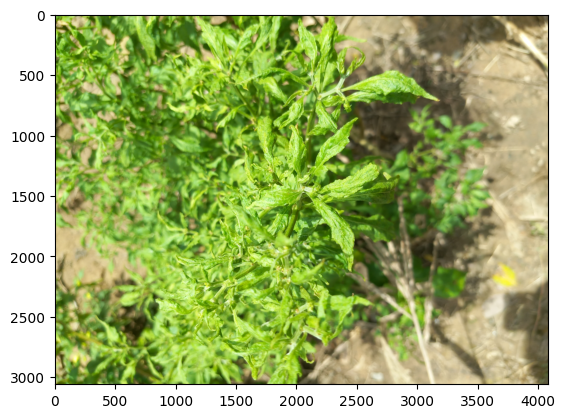

In [ ]:
from lime import lime_image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = os.path.join(image_dir, test_data['Image_ID'].iloc[0])
print("Sample Image")
img = load_img(sample_image_path)
plt.imshow(img)
plt.show()


Sample Image


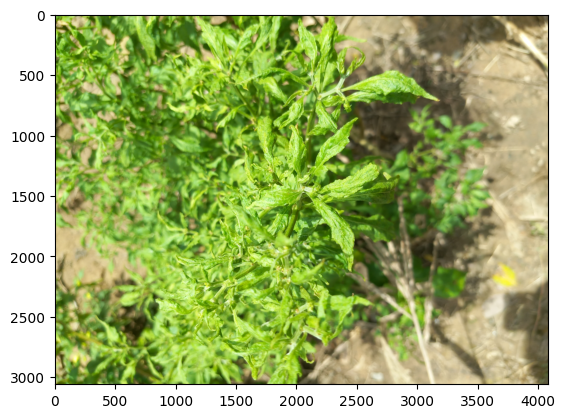

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

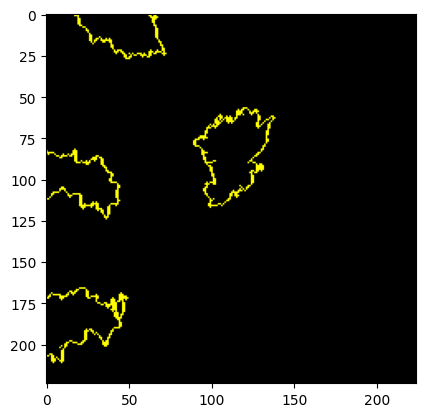

In [ ]:
# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Example: Explain a sample image prediction

sample_img = preprocess_image(sample_image_path).numpy()
explanation = explainer.explain_instance(sample_img, model.predict, top_labels=1, hide_color=0)

# Display explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False)
print("Image Boundaries")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()

Optimize Model for Edge Devices

In [ ]:
pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

def prune_weights(model, threshold=0.01):
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights, biases = layer.get_weights()
            weights[np.abs(weights) < threshold] = 0  # Prune small weights
            layer.set_weights([weights, biases])
    return model

pruned_model = prune_weights(model, threshold=0.01)
pruned_model.save('/content/drive/MyDrive/ghana/pruned_model_manual.keras')